In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest

In [3]:
useful_cols = ["year", "ukrptname", "ukrball", "histptname", "histball", "mathptname", "mathball", "engptname",
               "engball"]
data_raw = pd.read_csv('zno_preprocessed.csv', usecols=useful_cols)

In [4]:
df = data_raw

ball_col = [column for column in df.columns 
                     if column.endswith('ball')]
#scaling by max value
for col in ball_col:      
    for year in df.year.unique():
        
        max_val = df.loc[df['year']==year,col].max()
        df.loc[df['year']==year,col] = df.loc[df['year']==year,col].map(lambda x: x/max_val if x !=-1 else -1)


In [9]:
len(df)

1458122

## Ukrainian language

In [28]:
#select cols relevant only for ukr + year and filter out NaN values
df_ukr = df[["year", "ukrptname", "ukrball"]][~(df["ukrball"].isna() | df["ukrptname"].isna())]

In [27]:
len(df_ukr)

1158591

In [47]:
df_ukr_agg = df_ukr.groupby(["year", "ukrptname"]).agg({"ukrball": "mean"}).reset_index()

In [78]:
max_grades = df_ukr_agg[df_ukr_agg["year"] == 2020].max()
min_grades = df_ukr_agg[df_ukr_agg["year"] == 2020].min()

In [81]:
print('Lowest test center mean grade in ukrainian language')
print('###################################################')
print('Year: 2020')
print(f"Name: {min_grades['ukrptname']}")
print(f"Average ukr lang grade: {min_grades['ukrball']}")

Lowest test center mean grade in ukrainian language
###################################################
Year: 2020
Name: Івано-Франківський академічний ліцей-інтернат Івано-Франківської обласної ради
Average ukr lang grade: 0.23796122576610382


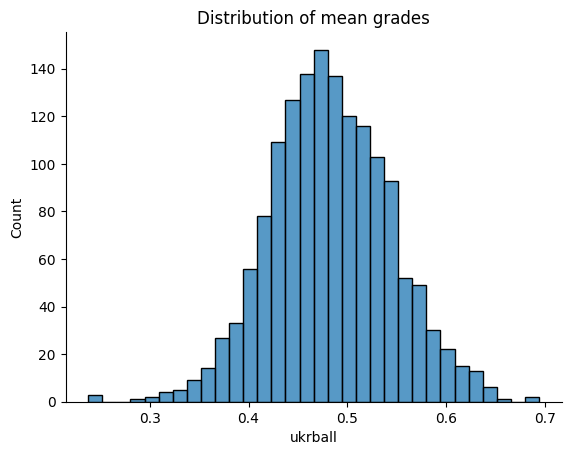

In [55]:
sns.histplot(df_ukr_agg[df_ukr_agg["year"] == 2020]['ukrball'])
plt.title("Distribution of mean grades")
sns.despine()

## Using Isolation forest for anomaly detection
some ideas and code taken for this medium article/tutorial, all credit due: https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

In [57]:
df_test = df_ukr_agg[df_ukr_agg["year"] == 2020]

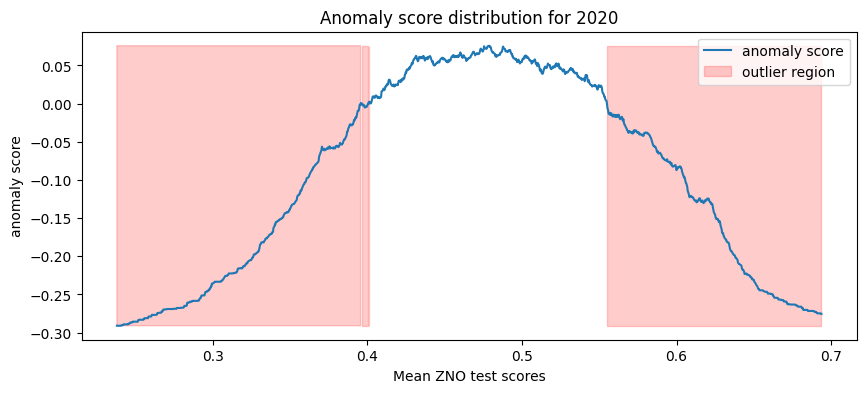

In [71]:
estimators = 150 #hyperparameter

isolation_forest = IsolationForest(n_estimators=estimators)
isolation_forest.fit(df_test["ukrball"].values.reshape(-1, 1))
xx = np.linspace(df_test["ukrball"].min(), df_test["ukrball"].max(), len(df_test)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.2, label='outlier region')
plt.legend()
plt.title("Anomaly score distribution for 2020")
plt.ylabel('anomaly score')
plt.xlabel('Mean ZNO test scores')
plt.show();